In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../src/')

In [3]:
import torch
import numpy as np

In [4]:
from networks.network import LLL_Net
from networks import tvmodels, set_tvmodel_head_var
from datasets.data_loader import get_datasets
import matplotlib.pyplot as plt
import seaborn as sns, numpy as np
import pandas as pd
import json

#### Load dataset

In [5]:
from datasets.dataset_config import dataset_config
from datasets.data_loader import get_loaders
from utils import seed_everything

In [6]:
# Loaders
SEED = 1993
seed_everything(SEED)
trn_loader, val_loader, tst_loader, taskcla = get_loaders(['imagenet_subset'], 1, None, 128, num_workers=4, pin_memory=False)

In [7]:
ds = tst_loader[0]

In [8]:
np.unique(ds.dataset.labels)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

### load labels

### simple labels

In [9]:
with open('imagenet-simple-labels.json') as f:
    classes_names = json.load(f)

print(classes_names[924]) # prints "guacamole"

guacamole


In [10]:
classes_names = np.array([classes_names[i] for i in ds.dataset.class_indices])

In [11]:
with open('imagenet_class_index.json') as f:
    classes_orig_names = {int(k): v  for k,v in json.load(f).items()}

classes_orig_names_list = [classes_orig_names[i][1] for i in ds.dataset.class_indices]

In [12]:
categories_df = pd.read_csv('imagenet_categories.csv')

In [13]:
class_idx_to_group = {}
class_to_group = {}
group_classes = {}
groups = []
classes_group_idx = [0] * len(ds.dataset.class_indices)

for c, row in categories_df.set_index('category').iterrows():
    labels = [v for v in row.values.tolist() if type(v) == str]
    
    if len(set(labels).intersection(set(classes_orig_names_list))) == 0:
        continue
    
    group_classes[c] = labels
    groups.append(c)
    for l in labels:
        if l in classes_orig_names_list:
            class_to_group[l] = c
            if l == 'crane (bird)': # (134, 'crane'),
                idx = 134
            else:
                idx = classes_orig_names_list.index(l)

            class_idx_to_group[idx] = c
            classes_group_idx[idx] = len(groups) - 1

print('classes_group_idx: ', len(classes_group_idx))
print('classes_group_idx: ', len(ds.dataset.class_indices))

classes_group_idx:  100
classes_group_idx:  100


In [14]:
len(groups)

13

In [15]:
subset_groups = np.unique([classes_group_idx[c] for c in ds.dataset.class_indices]).tolist()
subset_groups

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

In [16]:
group_color = [ 'red', 'green', 'blue', 'cyan', 'navy', 'magenta', 'pink', 'violet', 'orange', 
               'mediumpurple', 'midnightblue', 'slategray', 'darkcyan', 'khaki'
              ]

class_colors = {i:group_color[subset_groups.index(classes_group_idx[c])] for i,c in enumerate(ds.dataset.class_indices)}

In [17]:
[(i, ds.dataset.class_indices[i], classes_names[i], class_idx_to_group[i], group_color[subset_groups.index(classes_group_idx[i])]) for i in range(len(ds.dataset.class_indices))]

[(0, 68, 'sidewinder', 'snake', 'midnightblue'),
 (1, 56, 'kingsnake', 'snake', 'midnightblue'),
 (2, 78, 'tick', 'bug', 'blue'),
 (3, 8, 'hen', 'bird', 'green'),
 (4, 23, 'vulture', 'bird', 'green'),
 (5, 84, 'peacock', 'bird', 'green'),
 (6, 90, 'lorikeet', 'bird', 'green'),
 (7, 65, 'sea snake', 'fish', 'magenta'),
 (8, 74, 'European garden spider', 'arachnid', 'red'),
 (9, 76, 'tarantula', 'arachnid', 'red'),
 (10, 40, 'Carolina anole', 'lizard', 'violet'),
 (11, 89, 'sulphur-crested cockatoo', 'bird', 'green'),
 (12, 3, 'tiger shark', 'shark', 'mediumpurple'),
 (13, 92, 'bee eater', 'bird', 'green'),
 (14, 55, 'smooth green snake', 'snake', 'midnightblue'),
 (15, 9, 'ostrich', 'bird', 'green'),
 (16, 26, 'smooth newt', 'salamander', 'orange'),
 (17, 80, 'black grouse', 'bird', 'green'),
 (18, 43, 'frilled-necked lizard', 'lizard', 'violet'),
 (19, 38, 'banded gecko', 'lizard', 'violet'),
 (20, 58, 'water snake', 'snake', 'midnightblue'),
 (21, 70, 'harvestman', 'arachnid', 'red'),

In [18]:
ds_class_colors = np.array([class_colors[i] for i in ds.dataset.class_indices])
ds_classes_names = np.array([classes_names[i] for i in ds.dataset.class_indices])

### Check on sample

In [19]:
from torchvision.utils import make_grid

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[(82, 'terrapin', 'terrapin', ['n01797886', 'ruffed_grouse']),
 (78, 'American bullfrog', 'American bullfrog', ['n01776313', 'tick']),
 (42, 'yellow garden spider', 'yellow garden spider', ['n01687978', 'agama']),
 (82, 'terrapin', 'terrapin', ['n01797886', 'ruffed_grouse']),
 (86,
  'southern black widow',
  'southern black widow',
  ['n01807496', 'partridge']),
 (7, 'sea snake', 'sea snake', ['n01514668', 'cock']),
 (22, 'wolf spider', 'wolf spider', ['n01614925', 'bald_eagle']),
 (47, 'brambling', 'brambling', ['n01694178', 'African_chameleon'])]

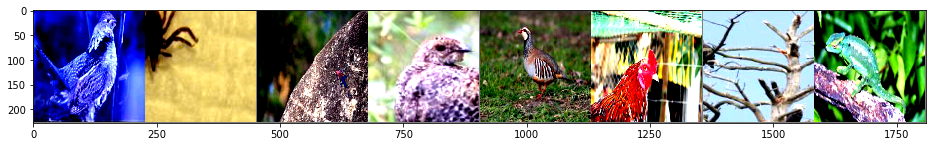

In [20]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(8*2, 3))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trn_loader[0])
images, labels = next(dataiter)


imshow(make_grid(images[:8]))
[ (ds.dataset.class_indices[l], 
   classes_names[ds.dataset.class_indices[l]],
   ds_classes_names[l],
  classes_orig_names[ds.dataset.class_indices[l]]
  )  for l in labels[:8]]

## Evaluate Test dataset

#### load dataset

In [24]:
from torchvision.models import resnet18
from networks import set_tvmodel_head_var
init_model = resnet18()
set_tvmodel_head_var(init_model)

In [25]:
MODEL_FILE = '../results/imagenet_subset_finetune_in_subset_100_ft_single_task/models/task0.ckpt'

model = LLL_Net(init_model, remove_existing_head=True)
model.add_head(len(ds.dataset.class_indices))
model.load_state_dict(torch.load(MODEL_FILE))
model.cuda()

LLL_Net(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runni

In [36]:
n_all = 0
n_correct = 0
nb_classes = 100
confusion_matrix = torch.zeros(nb_classes, nb_classes)

model.cuda()
model.eval()
with torch.no_grad():
    for i, (inputs, labels) in enumerate(tst_loader[0]):
        inputs = inputs.cuda()
        labels = labels.cuda()
        outputs = model(inputs)[0]
        preds = outputs.argmax(1)
        n_all += labels.size(0)
        n_correct += (preds == labels).sum().item()
        for t, p in zip(labels.view(-1), preds.view(-1)):
            confusion_matrix[t.long(), p.long()] += 1

Model accuracy: 

In [37]:
n_correct / n_all

0.7414

In [46]:
cm = confusion_matrix.cpu().numpy()

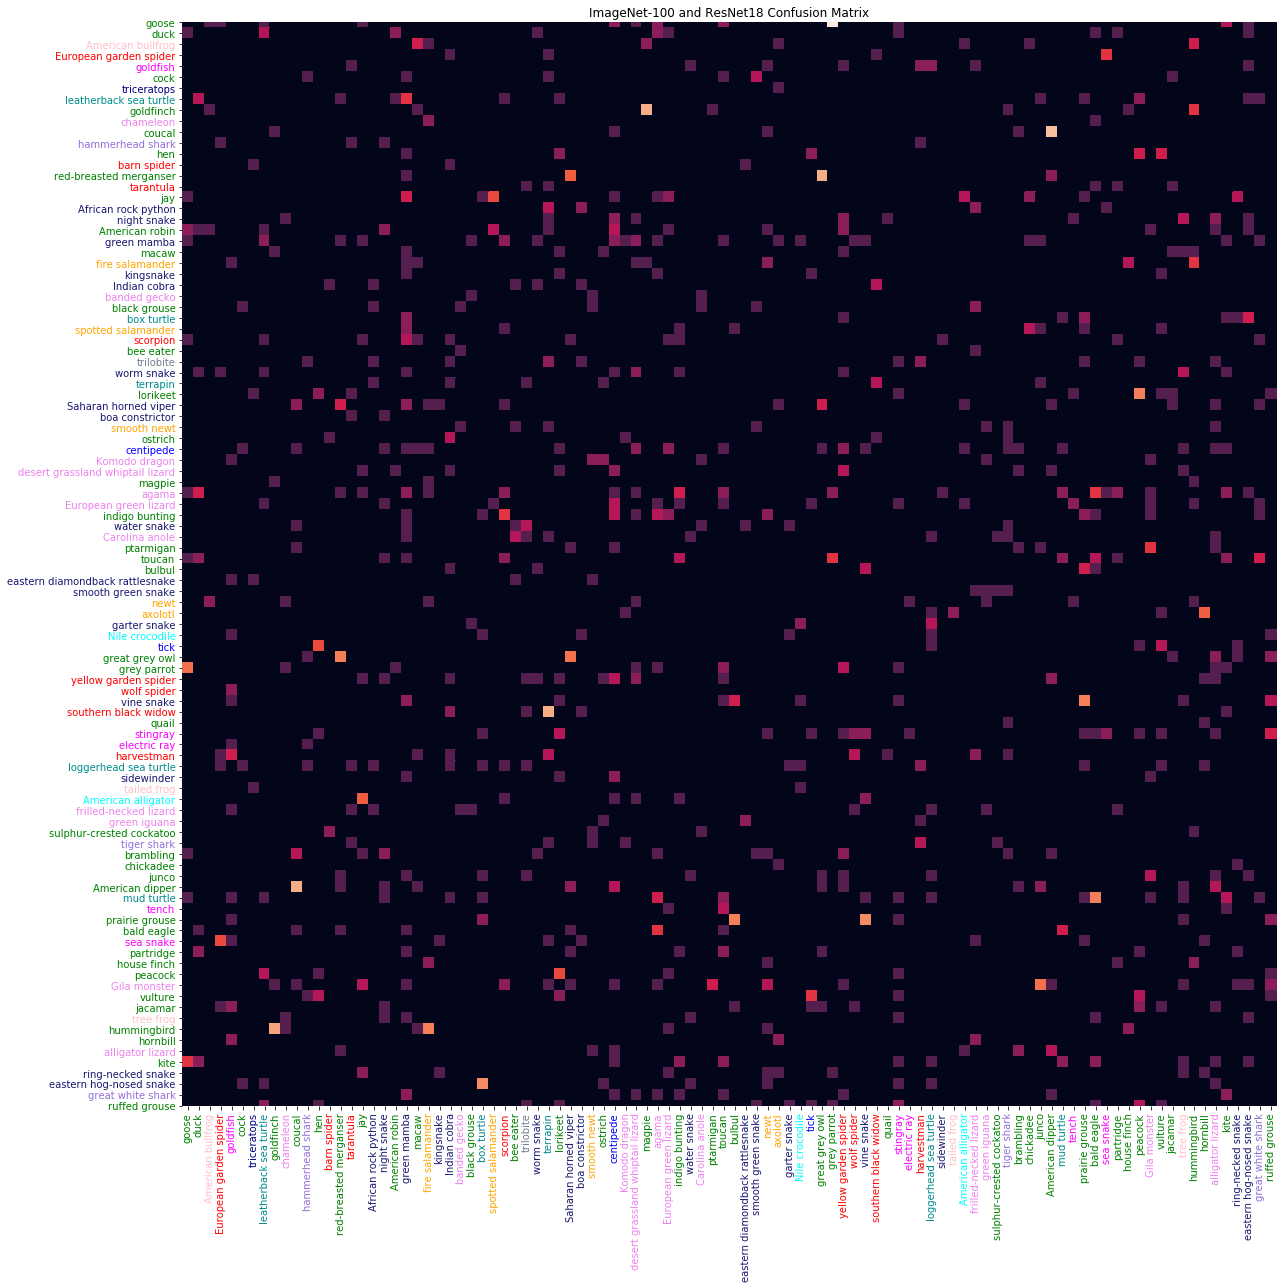

In [49]:
def apply_permutation(cm, perm):
    return cm[perm].transpose()[perm].transpose()

def plot_cm(cm, order = np.arange(100), log=True, title='ImageNet-100 and ResNet18 Confusion Matrix', filename=None):
    m = cm
    if log:
        m = np.log(m + 1)
    m[np.arange(m.shape[0]), np.arange(m.shape[1])] = 0
    m = apply_permutation(m, order)
    x = ds_classes_names[order]
    plt.figure(figsize=(18,18))
    ax = sns.heatmap(m, xticklabels=x, yticklabels=x, square = True, cbar=False, )
    plt.title(title)
    for xtick, ytick, c_idx in zip(ax.get_xticklabels(), ax.get_yticklabels(), order): 
        xtick.set_color(class_colors[c_idx]); ytick.set_color(class_colors[c_idx]);
    
    if filename:
        plt.tight_layout()
        plt.savefig(filename)
    
plot_cm(cm, filename='fig/in_subset_cm_random.png')

### order by coarse grained labels

In [50]:
groups_perm = [i for _, i in sorted([(class_colors[i], i) for i in range(len(ds.dataset.class_indices))])]

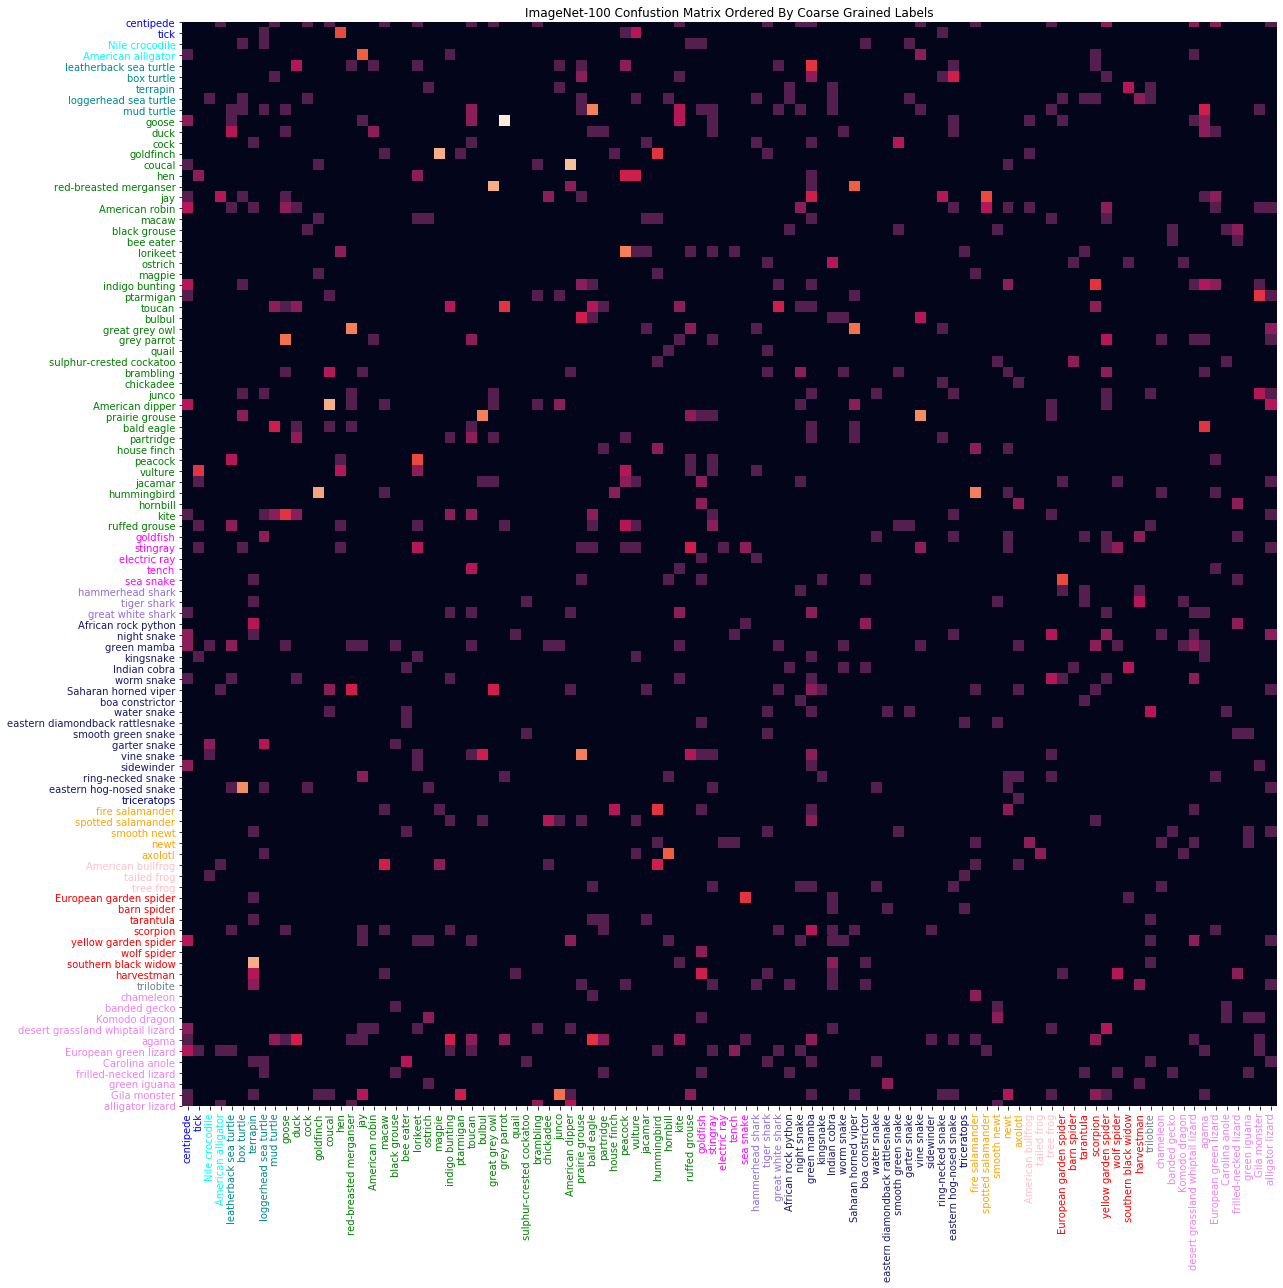

In [52]:
plot_cm(cm, order=groups_perm, title='ImageNet-100 Confustion Matrix Ordered By Coarse Grained Labels', filename='fig/in_subset_cm_categories.png')

## Confustion Matrix Ordering

In [53]:
def calculate_weight_matrix(n):
    weights = np.abs(np.arange(n) - np.arange(n)[:, None])
    weights = np.array(weights, dtype=np.float)
    for i in range(n):
        for j in range(n):
            if i == j:
                continue
            weights[i][j] += (i + j) * 0.01
    return weights

def calculate_score(cm, weights):
    return int(np.tensordot(cm, weights, axes=((0, 1), (0, 1))))

This weight matrix will be used for weighting cm values. 

In this case, we would like to get results "along" the diagonal of cm matrix.

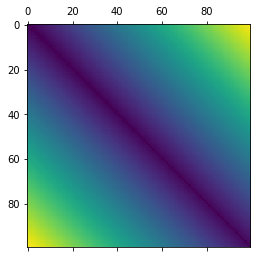

In [54]:
weights = calculate_weight_matrix(100)
plt.matshow(weights)

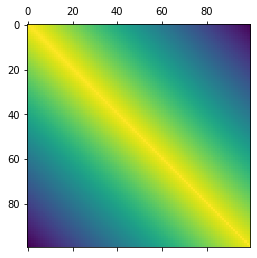

In [55]:
plt.matshow(-weights) # this is inverse

In [56]:
import random
from tqdm.autonotebook import tqdm

def swap(cm, i, j):
    """
    Swap row and column i and j in-place.
    Parameters
    ----------
    cm : ndarray
    i : int
    j : int
    Examples
    --------
    >>> cm = np.array([[0, 1, 2], [3, 4, 5], [6, 7, 8]])
    >>> swap(cm, 2, 0)
    array([[8, 7, 6],
           [5, 4, 3],
           [2, 1, 0]])
    """
    # swap columns
    copy = cm[:, i].copy()
    cm[:, i] = cm[:, j]
    cm[:, j] = copy
    # swap rows
    copy = cm[i, :].copy()
    cm[i, :] = cm[j, :]
    cm[j, :] = copy
    return cm


def move_1d(perm, from_start, from_end, insert_pos):
    """
    Move a block in a list.
    Parameters
    ----------
    perm : ndarray
        Permutation
    from_start : int
    from_end : int
    insert_pos : int
    Returns
    -------
    perm : ndarray
        The new permutation
    """
    if not (insert_pos < from_start or insert_pos > from_end):
        raise ValueError(
            "insert_pos={} needs to be smaller than from_start={}"
            " or greater than from_end={}".format(insert_pos, from_start, from_end)
        )
    if insert_pos > from_end:
        p_new = list(range(from_end + 1, insert_pos + 1)) + list(
            range(from_start, from_end + 1)
        )
    else:
        p_new = list(range(from_start, from_end + 1)) + list(
            range(insert_pos, from_start)
        )
    p_old = sorted(p_new)
    perm[p_old] = perm[p_new]
    return perm


def move(cm, from_start, from_end, insert_pos):
    """
    Move rows from_start - from_end to insert_pos in-place.
    Parameters
    ----------
    cm : ndarray
    from_start : int
    from_end : int
    insert_pos : int
    Returns
    -------
    cm : ndarray
    Examples
    --------
    >>> cm = np.array([[0, 1, 2, 3], [4, 5, 6, 7], [8, 9, 0, 1], [2, 3, 4, 5]])
    >>> move(cm, 1, 2, 0)
    array([[5, 6, 4, 7],
           [9, 0, 8, 1],
           [1, 2, 0, 3],
           [3, 4, 2, 5]])
    """
    if not (insert_pos < from_start or insert_pos > from_end):
        raise ValueError(
            "insert_pos={} needs to be smaller than from_start={}"
            " or greater than from_end={}".format(insert_pos, from_start, from_end)
        )
    if insert_pos > from_end:
        p_new = list(range(from_end + 1, insert_pos + 1)) + list(
            range(from_start, from_end + 1)
        )
    else:
        p_new = list(range(from_start, from_end + 1)) + list(
            range(insert_pos, from_start)
        )
    p_old = sorted(p_new)
    # swap columns
    cm[:, p_old] = cm[:, p_new]
    # swap rows
    cm[p_old, :] = cm[p_new, :]
    return cm


def swap_1d(perm, i, j):
    perm[i], perm[j] = perm[j], perm[i]
    return perm

def apply_permutation(cm, perm):
    return cm[perm].transpose()[perm].transpose()


def generate_permutation(n, current_perm, tmp_cm):
    """
    Generate a new permutation.
    Parameters
    ----------
    n : int
    current_perm : List[int]
    tmp_cm : np.ndarray
    Return
    ------
    perm, make_swap : List[int], bool
    """
    swap_prob = 0.5
    make_swap = random.random() < swap_prob
    if n < 3:
        # In this case block-swaps don't make any sense
        make_swap = True
    if make_swap:
        # Choose what to swap
        i = random.randint(0, n - 1)
        j = i
        while j == i:
            j = random.randint(0, n - 1)
        # Define permutation
        perm = swap_1d(current_perm.copy(), i, j)
        # Define values after swap
        tmp_cm = swap(tmp_cm, i, j)
    else:
        # block-swap
        block_len = n
        while block_len >= n - 1:
            from_start = random.randint(0, n - 3)
            from_end = random.randint(from_start + 1, n - 2)
            block_len = from_start - from_end
        insert_pos = from_start
        while not (insert_pos < from_start or insert_pos > from_end):
            insert_pos = random.randint(0, n - 1)
        perm = move_1d(current_perm.copy(), from_start, from_end, insert_pos)

        # Define values after swap
        tmp_cm = move(tmp_cm, from_start, from_end, insert_pos)
    return perm, make_swap


def simulated_annealing(
    current_cm,
    current_perm=None,
    score=calculate_score,
    steps=2 * 10 ** 5,
    temp=100.0,
    cooling_factor=0.99,
    deterministic=False,
    calculate_weight_matrix=calculate_weight_matrix
):
    """
    Optimize current_cm by randomly swapping elements.
    Parameters
    ----------
    current_cm : ndarray
    current_perm : None or iterable, optional (default: None)
    steps : int, optional (default: 2 * 10**4)
    temp : float > 0.0, optional (default: 100.0)
        Temperature
    cooling_factor: float in (0, 1), optional (default: 0.99)
    Returns
    -------
    best_result : Dict[str, Any]
        "best_cm"
        "best_perm"
    """
    if temp <= 0.0:
        raise ValueError("temp={} needs to be positive".format(temp))
    if cooling_factor <= 0.0 or cooling_factor >= 1.0:
        raise ValueError(
            "cooling_factor={} needs to be in the interval "
            "(0, 1)".format(cooling_factor)
        )
    n = len(current_cm)
    if current_perm is None:
        current_perm = list(range(n))
    current_perm = np.array(current_perm)

    # Pre-calculate weights
    weights = calculate_weight_matrix(n)

    # Apply the permutation
    current_cm = apply_permutation(current_cm, current_perm)
    current_score = score(current_cm, weights)

    best_cm = current_cm
    best_score = current_score
    best_perm = current_perm

    _scores=[]
    _scores_step = 1000
    
    # print("## Starting Score: {:0.2f}".format(current_score))
    pbar = tqdm(range(steps))
    for step in pbar:
        tmp_cm = np.array(current_cm, copy=True)
        perm, make_swap = generate_permutation(n, current_perm, tmp_cm)
        tmp_score = score(tmp_cm, weights)

        # Should be swapped?
        if deterministic:
            chance = 1.0
        else:
            chance = random.random()
            temp *= 0.99
        hot_prob_thresh = min(1, np.exp(-(tmp_score - current_score) / temp))
        if chance <= hot_prob_thresh:
            changed = False
            if best_score > tmp_score:  # minimize
                best_perm = perm
                best_cm = tmp_cm
                best_score = tmp_score
                changed = True
            current_score = tmp_score
            current_cm = tmp_cm
            current_perm = perm
            
            if changed:
                pbar.set_description("Current: %0.2f (best: %0.2f)" % (current_score, best_score))
#                 print(
#                     (
#                         "Current: %0.2f (best: %0.2f, "
#                         "hot_prob_thresh=%0.4f%%, step=%i, swap=%s)"
#                     ) % (
#                     current_score,
#                     best_score,
#                     (hot_prob_thresh * 100),
#                     step,
#                     str(make_swap)
#                 ))
        if step > _scores_step * 2 and step % _scores_step == 0:
            _scores.append(best_score)

    plt.figure()
    plt.plot(np.arange(len(_scores)) * _scores_step, _scores)
    plt.title('Optimization scrore')
    
    return {"cm": best_cm, "perm": best_perm, "scores": _scores}


/home/btwardow/miniconda3/envs/deep_metric_learning/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


/home/btwardow/miniconda3/envs/deep_metric_learning/lib/python3.6/site-packages/ipykernel_launcher.py:223: RuntimeWarning: overflow encountered in exp


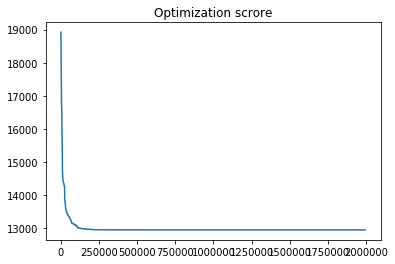

In [57]:
STEPS = 20 * 10 ** 5
# max confusion
r = simulated_annealing(cm.copy(), steps=STEPS)
split_max_confusion_sa = r['perm']
cm_max_sa = r['cm']

In [58]:
def calculate_score_min(cm, weights):
    return  -1 * int(np.tensordot(cm, weights, axes=((0, 1), (0, 1))))

/home/btwardow/miniconda3/envs/deep_metric_learning/lib/python3.6/site-packages/ipykernel_launcher.py:223: RuntimeWarning: overflow encountered in exp


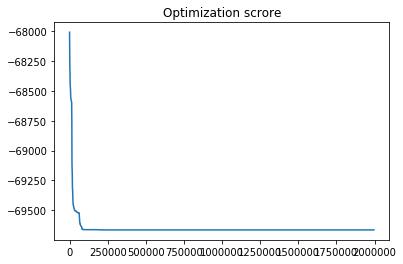

In [59]:
r = simulated_annealing(cm.copy(), steps=STEPS, score=calculate_score_min)
split_min_confusion_sa = r['perm']
cm_min_sa = r['cm']

In [60]:
calculate_weight_matrix(100).max()

99.99

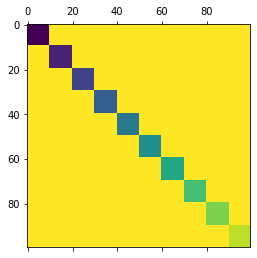

In [61]:
def calculate_weight_matrix_tasks(n, n_tasks=10):
    weights = np.ones((n, n)) * 99.9
    tc = int(nb_classes / n_tasks)
    for i_start in range(0, nb_classes, tc):
        i_end = i_start + tc
        weights[i_start:i_end, i_start:i_end] = i_start 
    return weights

plt.matshow(calculate_weight_matrix_tasks(100))

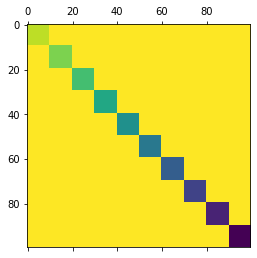

In [62]:
def calculate_weight_matrix_tasks2(n, n_tasks=10):
    weights = np.ones((n, n)) * 99.9
    tc = int(nb_classes / n_tasks)
    for i_start in range(0, nb_classes, tc):
        i_end = i_start + tc
        weights[i_start:i_end, i_start:i_end] = 100 - i_end
    return weights

plt.matshow(calculate_weight_matrix_tasks2(100))

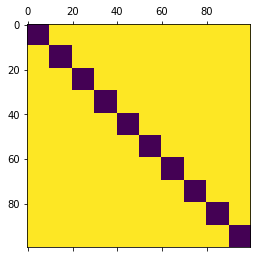

In [63]:
def calculate_weight_matrix_tasks3(n, n_tasks=10):
    weights = np.ones((n, n)) * 99.9
    tc = int(nb_classes / n_tasks)
    for i_start in range(0, nb_classes, tc):
        i_end = i_start + tc
        weights[i_start:i_end, i_start:i_end] = 0
    return weights

plt.matshow(calculate_weight_matrix_tasks3(100))

/home/btwardow/miniconda3/envs/deep_metric_learning/lib/python3.6/site-packages/ipykernel_launcher.py:223: RuntimeWarning: overflow encountered in exp


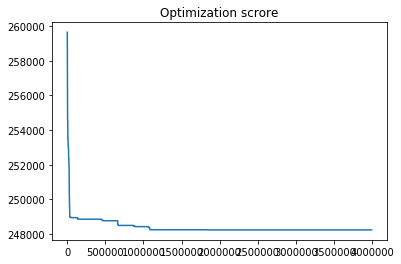

In [64]:
r = simulated_annealing(cm.copy(), steps=2* STEPS, calculate_weight_matrix=calculate_weight_matrix_tasks)
split_max_confusion_sa_tasks = r['perm']
cm_max_sa_tasks = r['cm']

/home/btwardow/miniconda3/envs/deep_metric_learning/lib/python3.6/site-packages/ipykernel_launcher.py:223: RuntimeWarning: overflow encountered in exp


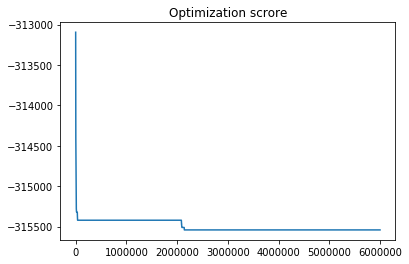

In [65]:
r = simulated_annealing(cm.copy(), steps=3* STEPS, score=calculate_score_min, calculate_weight_matrix=calculate_weight_matrix_tasks)
split_min_confusion_sa_tasks = r['perm']
cm_min_sa_tasks = r['cm']

/home/btwardow/miniconda3/envs/deep_metric_learning/lib/python3.6/site-packages/ipykernel_launcher.py:223: RuntimeWarning: overflow encountered in exp


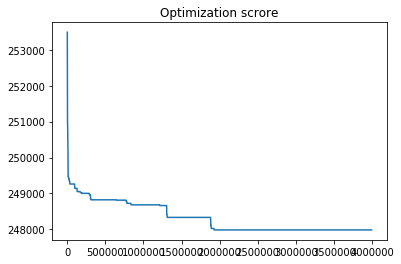

In [66]:
r = simulated_annealing(cm.copy(), steps=2* STEPS, calculate_weight_matrix=calculate_weight_matrix_tasks2)
split_inc_confusion_sa_tasks = r['perm']
cm_inc_sa_tasks = r['cm']

/home/btwardow/miniconda3/envs/deep_metric_learning/lib/python3.6/site-packages/ipykernel_launcher.py:223: RuntimeWarning: overflow encountered in exp


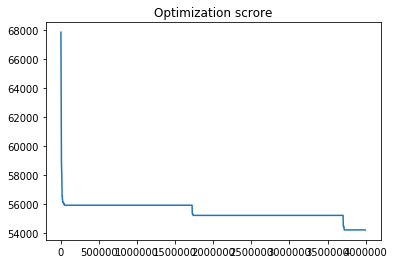

In [67]:
r = simulated_annealing(cm.copy(), steps=2* STEPS, calculate_weight_matrix=calculate_weight_matrix_tasks3)
split_eq_confusion_sa_tasks = r['perm']
cm_eq_sa_tasks = r['cm']

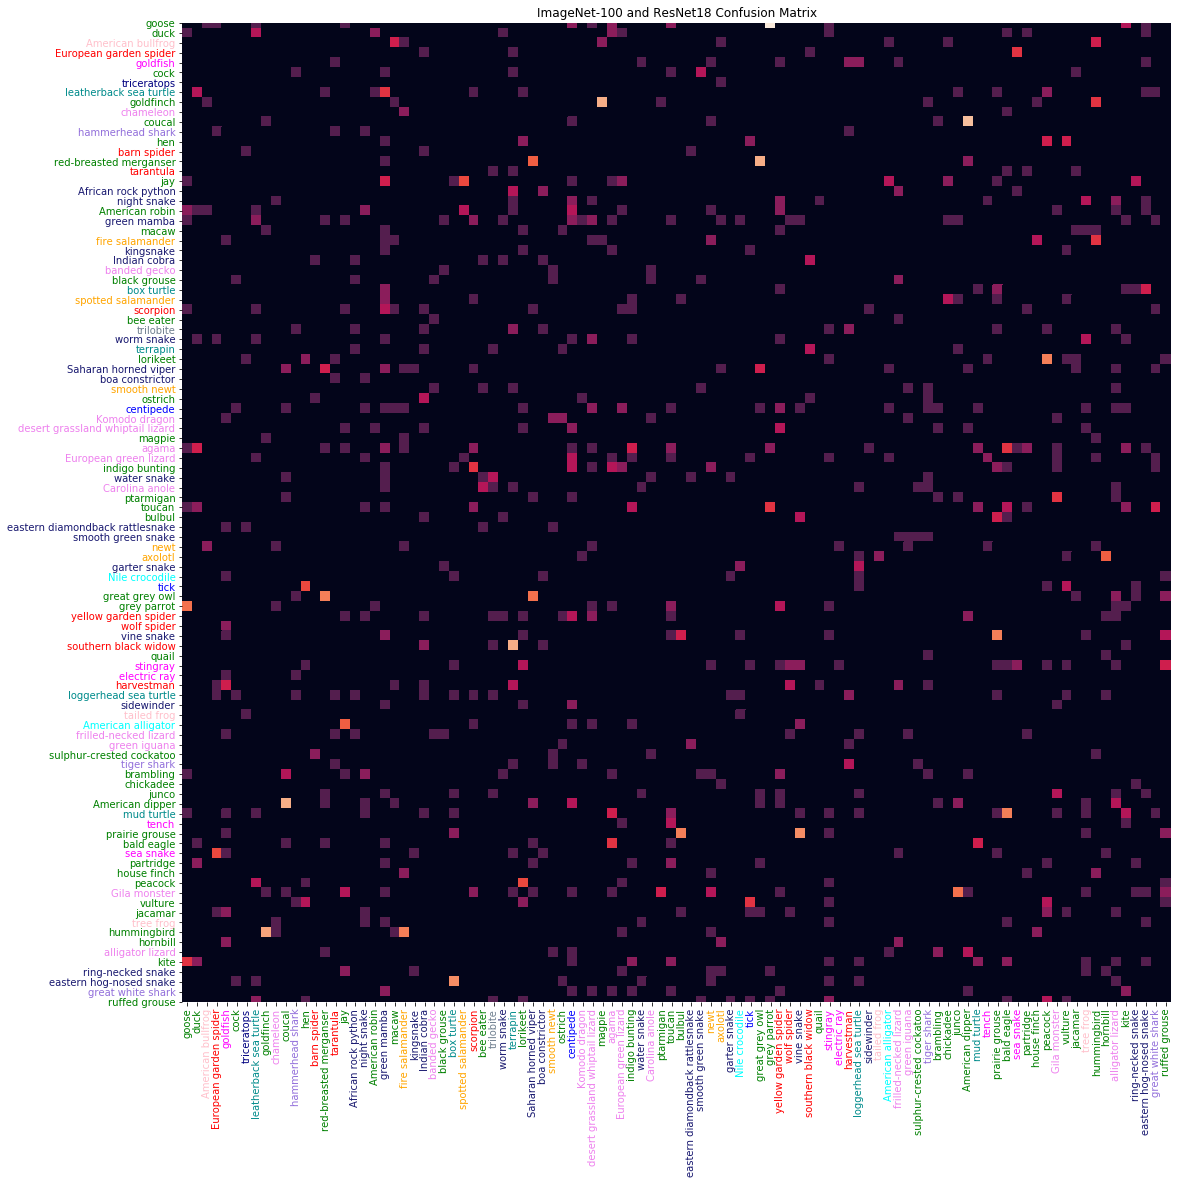

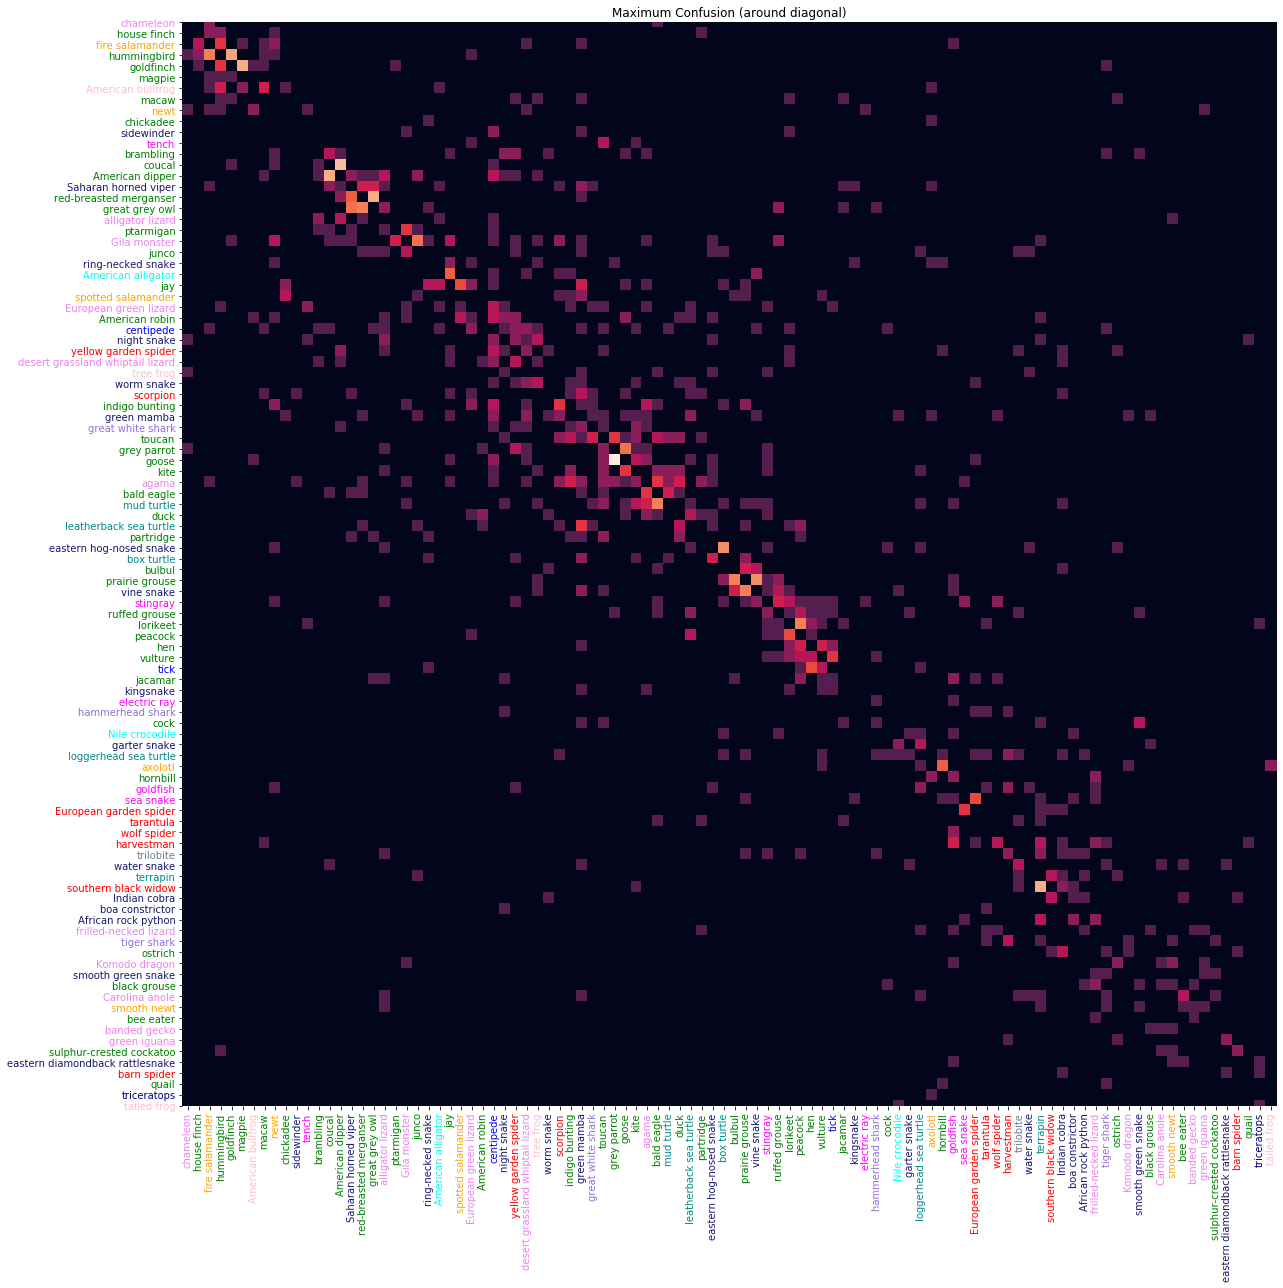

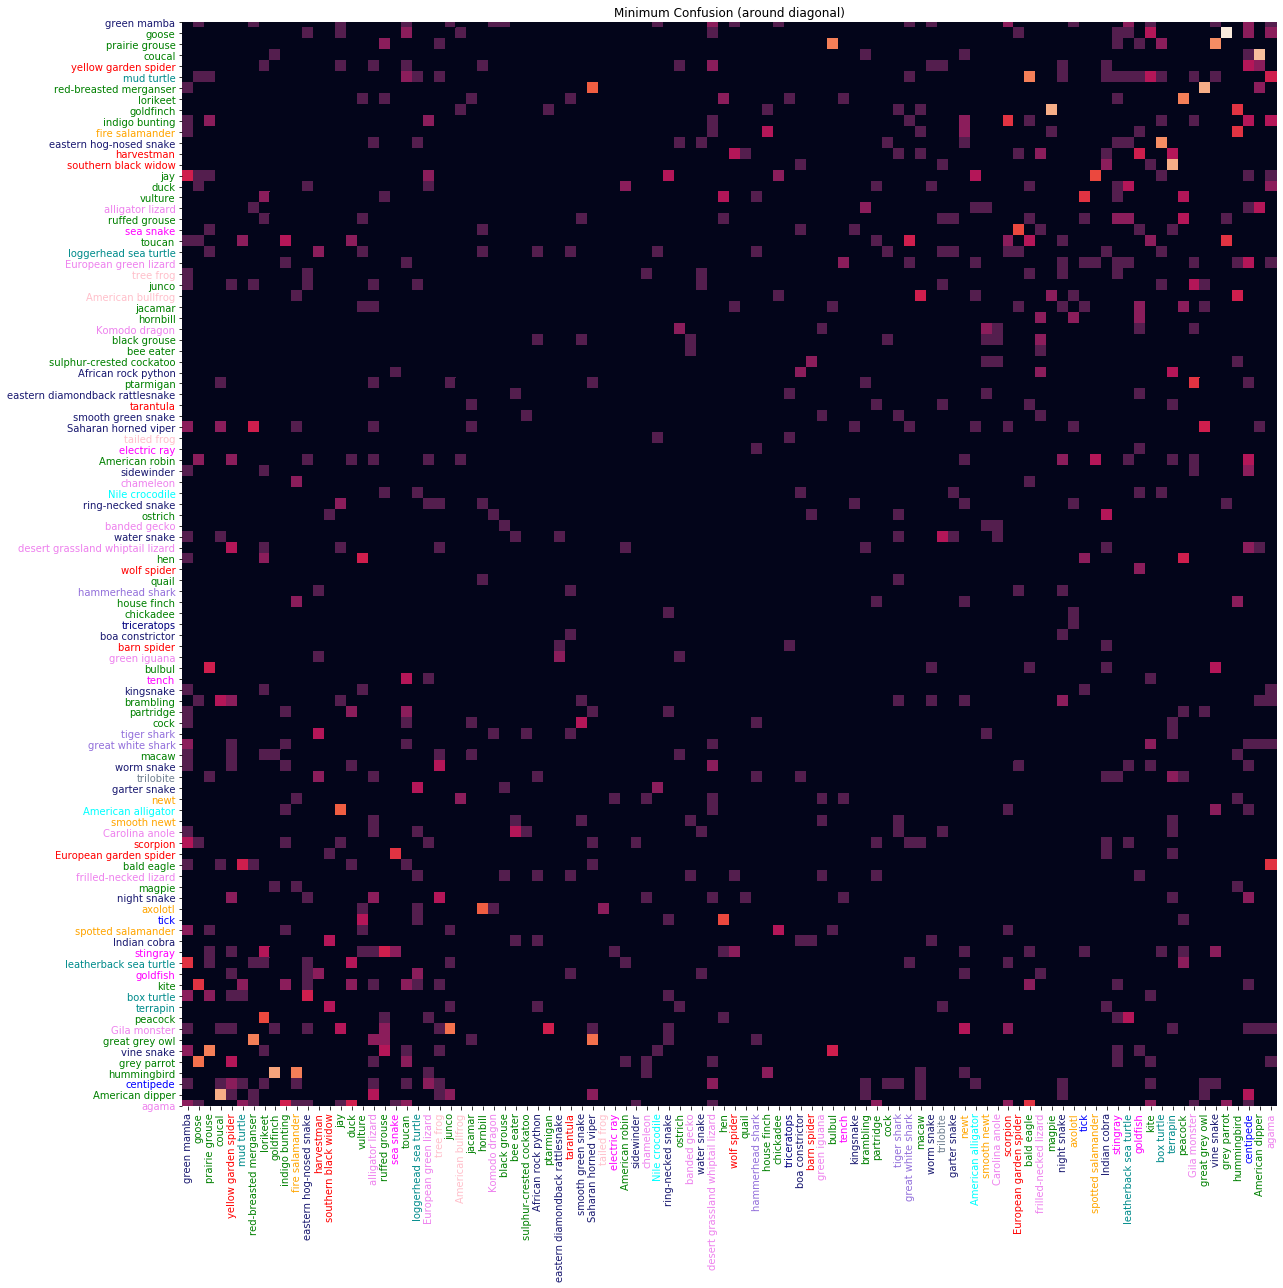

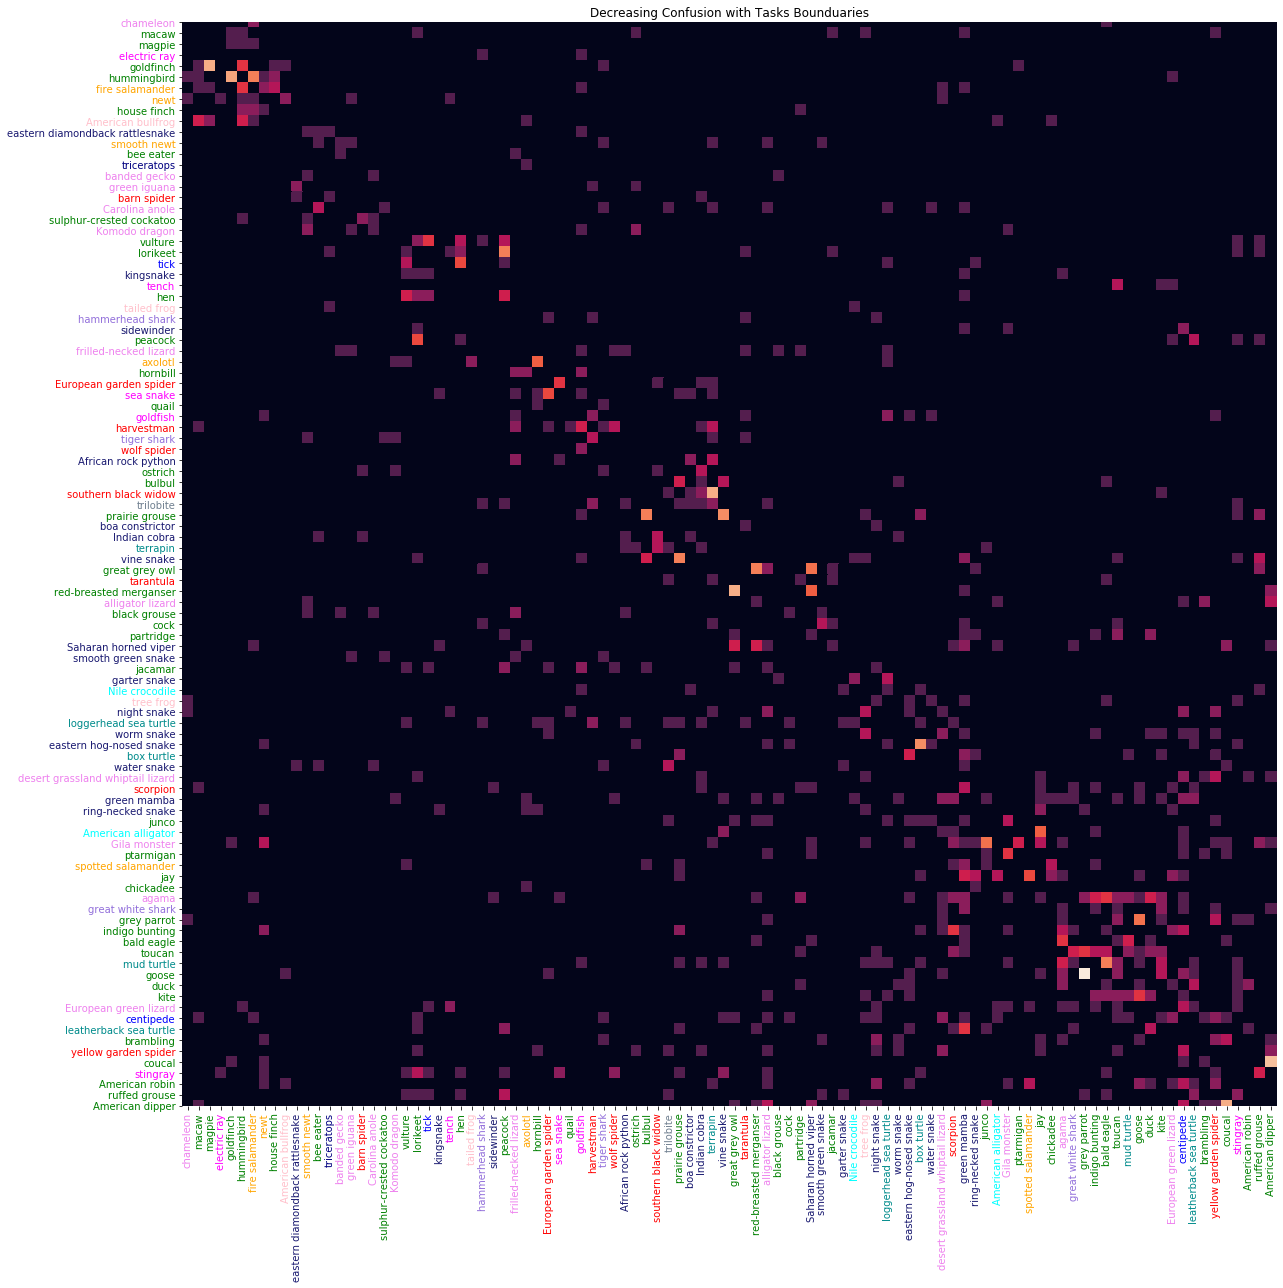

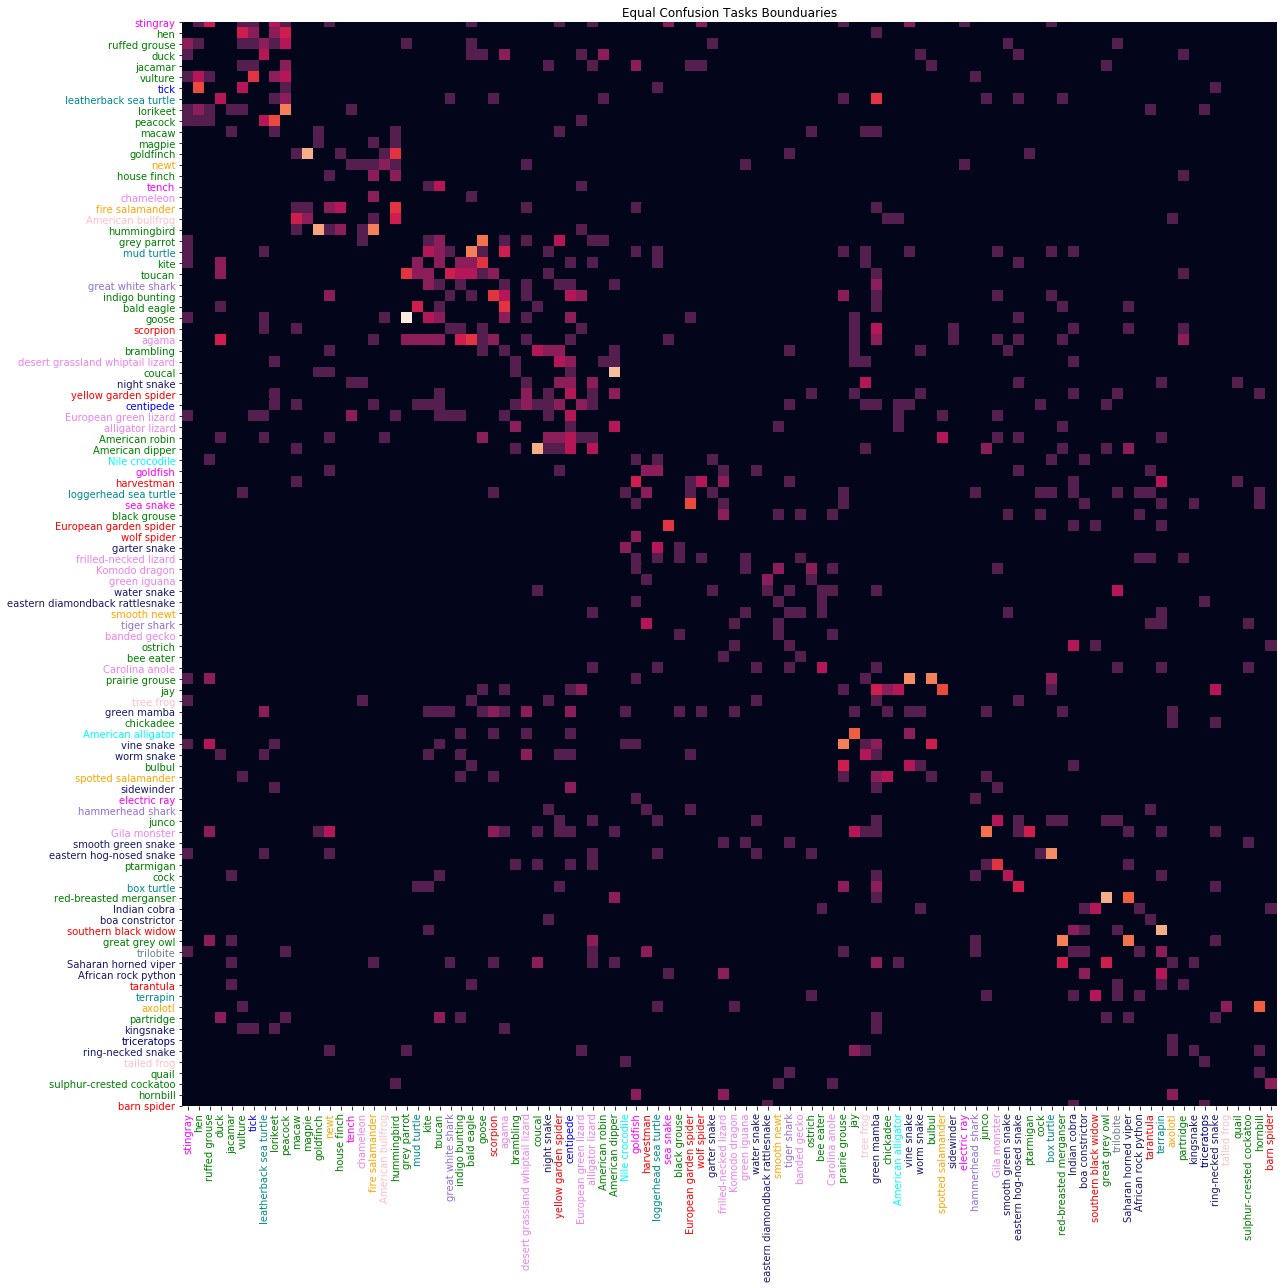

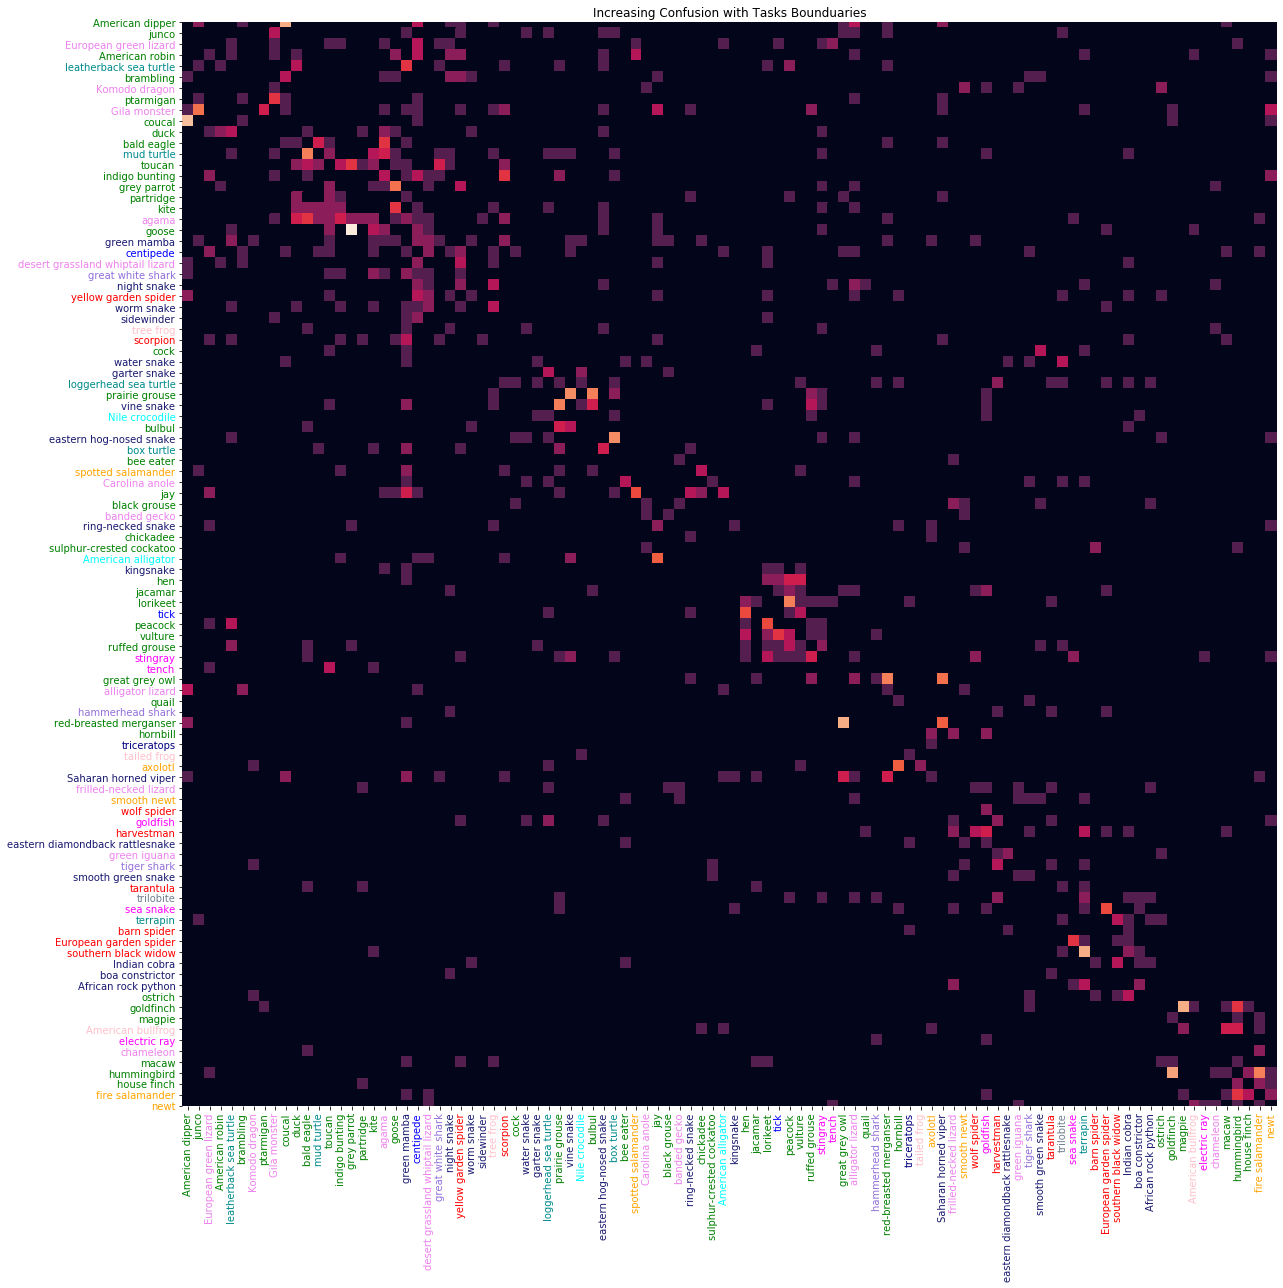

In [68]:
plot_cm(cm)
plot_cm(cm, order=split_max_confusion_sa, title = 'Maximum Confusion (around diagonal)', filename='fig/in_subset_cm_max_conf.png')
plot_cm(cm, order=split_min_confusion_sa, title = 'Minimum Confusion (around diagonal)', filename='fig/in_subset_cm_min_conf.png')
plot_cm(cm, order=split_max_confusion_sa_tasks, title = 'Decreasing Confusion with Tasks Bounduaries', filename='fig/in_subset_cm_task_dec.png')
plot_cm(cm, order=split_eq_confusion_sa_tasks, title = 'Equal Confusion Tasks Bounduaries', filename='fig/in_subset_cm_task_eq.png')
# plot_cm(cm, order=split_min_confusion_sa_tasks, title = 'Minimum Confusion with Tasks Bounduaries')
plot_cm(cm, order=split_inc_confusion_sa_tasks, title = 'Increasing Confusion with Tasks Bounduaries', filename='fig/in_subset_cm_task_inc.png')

## Labels orders

In [85]:
DATASET_CONFIG_FORMAT = \
"""
    'imagenet_subset_#SUFFIX#': {
        'path': '/data2/dataset/Framework/ILSVRC12_256/',
        'resize': None,
        'crop': 224,
        'flip': True,
        'normalize': ((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        'class_order': [ #ORDERING# ]
    },"""

In [86]:
print([ds.dataset.class_indices[i] for i in split_max_confusion_sa])

[76, 75, 77, 73, 74, 72, 78, 70, 71, 25, 0, 69, 47, 40, 46, 59, 55, 64, 39, 31, 32, 30, 29, 27, 26, 28, 79, 38, 44, 43, 42, 41, 48, 45, 53, 52, 58, 57, 54, 66, 68, 67, 60, 61, 62, 56, 65, 63, 49, 50, 37, 36, 35, 34, 33, 6, 5, 3, 4, 2, 51, 1, 87, 89, 84, 97, 98, 99, 96, 93, 23, 7, 8, 9, 22, 21, 81, 20, 82, 86, 85, 83, 80, 18, 12, 15, 91, 14, 17, 10, 16, 13, 19, 94, 11, 95, 92, 24, 90, 88]


In [87]:
for suffix, ordering in [
    ('cm_max', split_max_confusion_sa), 
    ('cm_min', split_min_confusion_sa), 
    ('cm_10tasks_cm_dec', split_max_confusion_sa_tasks), 
    ('cm_10tasks_cm_eq', split_eq_confusion_sa_tasks), 
    ('cm_10tasks_cm_inc', split_inc_confusion_sa_tasks), 
]:
    s = DATASET_CONFIG_FORMAT.replace('#ORDERING#', ','.join([str(ds.dataset.class_indices[i]) for i in ordering]))
    s = s.replace('#SUFFIX#', suffix)
    print(s)
    


    'imagenet_subset_cm_max': {
        'path': '/data2/dataset/Framework/ILSVRC12_256/',
        'resize': None,
        'crop': 224,
        'flip': True,
        'normalize': ((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        'class_order': [ 76,75,77,73,74,72,78,70,71,25,0,69,47,40,46,59,55,64,39,31,32,30,29,27,26,28,79,38,44,43,42,41,48,45,53,52,58,57,54,66,68,67,60,61,62,56,65,63,49,50,37,36,35,34,33,6,5,3,4,2,51,1,87,89,84,97,98,99,96,93,23,7,8,9,22,21,81,20,82,86,85,83,80,18,12,15,91,14,17,10,16,13,19,94,11,95,92,24,90,88 ]
    },

    'imagenet_subset_cm_min': {
        'path': '/data2/dataset/Framework/ILSVRC12_256/',
        'resize': None,
        'crop': 224,
        'flip': True,
        'normalize': ((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        'class_order': [ 58,68,36,40,42,62,55,6,74,52,77,49,21,86,26,56,4,39,33,7,54,99,79,48,30,78,51,93,91,17,13,11,80,31,95,9,14,59,88,87,38,0,76,97,29,15,19,20,41,3,22,24,89,75,25,90,83,92,94,37,69,1,47,63,84,12,57,70,